## Lab1 - Set Cover Problem

In [69]:
from random import random, seed
from itertools import product
import numpy as np
np.random.seed(10)
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from itertools import accumulate

from icecream import ic

Define all helper functions

In order to reduce the size of the number of sets, I remove sets that do not cover any element (all False) and duplicates sets

In [70]:
def initialize_sets(UNIVERSE_SIZE, NUM_SETS, DENSITY):
    
    SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
    for s in range(UNIVERSE_SIZE):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(NUM_SETS), s] = True
    
    # Remove sets that do not cover any element (all False)
    row_sums = SETS.sum(axis=1)
    SETS = SETS[row_sums > 0]  # Remove rows with sum 0 (empty sets)
    
    # Remove duplicate sets
    unique_sets = np.unique(SETS, axis=0)
    
    return unique_sets

In [71]:
def random_generator(UNIVERSE_SIZE, NUM_SETS, DENSITY):
    return np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

# Calculate the cost for each set
def initialize_costs(SETS):
    return np.pow(SETS.sum(axis=1), 1.1)

def valid(solution, SETS):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution, COSTS):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution: np.array, SETS, COSTS):
    return (valid(solution, SETS), -cost(solution, COSTS))

#I decided to start with an initial condition that includes all sets with a cost of 1, which corresponds to those sets containing exactly one True element. This approach ensures that the solution begins with a good level of coverage at the minimum cost. 

In [72]:
def initialize_solution_based_on_cost(COSTS, length_SETS, parameter_initial_solution, rng):
    solution = np.array([False] * length_SETS)
    
    # Imposta a True (selezionato) gli insiemi con costo pari a 1
    solution[COSTS == 1] = True
    
    # Seleziona casualmente altri insiemi con probabilità data da parameter_initial_solution
    unselected_sets = np.logical_not(solution) # Trova i set non selezionati
    random_selection = rng.random(length_SETS) < parameter_initial_solution  # Randomizza selezione
    solution[unselected_sets] = random_selection[unselected_sets]  # Aggiorna solo quelli non selezionati
    
    return solution, unselected_sets

## Random Hill Climber

In [73]:
def random_hill_climbing(tweak, solution, SETS, COSTS, unselected_sets, rng, MAX_STEPS):
    
    # Initial fitness
    solution_fitness = fitness(solution, SETS, COSTS)
    history = [solution_fitness[1]] # Record the cost
    
    number_improvement = 0
    
    # Loop
    for steps in range(MAX_STEPS):
        new_solution = tweak(solution, unselected_sets, rng)
        new_fitness = fitness(new_solution, SETS, COSTS)
        
        # If the new solution is better, update the current solution
        if new_fitness > solution_fitness:
            number_improvement +=1
            solution = new_solution
            solution_fitness = new_fitness
        
        # Record the fitness value
        history.append(solution_fitness[1])
    
    return solution, solution_fitness, history, number_improvement

## RHC- Single mutation

#I modified the solution while leaving the sets with a cost of 1 unchanged for the same reasons previously mentioned.

In [75]:
def single_mutation_personalized(solution: np.ndarray, unselected_sets, rng) -> np.ndarray:

    new_solution = solution.copy()
    
    index_unselected = np.where(unselected_sets == True)[0]
    index = rng.choice(index_unselected)
    new_solution[index] = not new_solution[index]
    return new_solution

In [91]:
# Plot function 
def plot_history(history, solution_fitness, number_improvement):
    
    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, max)),
        color="red",
    )
    plt.scatter(range(len(history)), history, marker=".")
    plt.xlabel("Steps")
    plt.ylabel("Cost")
    
    plt.title(f'solution_fitness {solution_fitness} and number_improvement {number_improvement}')
    plt.show()

In [77]:
# function for the experiments
def experiments(UNIVERSE_SIZE, NUM_SETS, DENSITY, tweak, parameter_initial_solution):

    rng = random_generator(UNIVERSE_SIZE, NUM_SETS, DENSITY)
    SETS = initialize_sets(UNIVERSE_SIZE, NUM_SETS, DENSITY)
    COSTS = initialize_costs(SETS)
    length_SETS = len(SETS)
    
    initial_solution, unselected_sets = initialize_solution_based_on_cost(COSTS, length_SETS, parameter_initial_solution, rng)

    solution, solution_fitness, history, number_improvement= random_hill_climbing(tweak, initial_solution, SETS, COSTS, unselected_sets, rng, MAX_STEPS = 10000)

    ic(fitness(initial_solution, SETS, COSTS), solution_fitness, number_improvement)
    plot_history(history, solution_fitness, number_improvement)

In [ ]:
#Prove with these 6 different instance
UNIVERSE_SIZE_LIST = [100, 1_000, 10_000, 100_000, 100_000, 100_000]
NUM_SETS_LIST = [10, 100, 1_000, 10_000, 10_000, 10_000]
DENSITY_LIST = [.2, .2, .2, .1, .2, .3]

ic| fitness(initial_solution, SETS, COSTS): (np.True_, np.float64(-265771.964121684))
    solution_fitness: (np.True_, np.float64(-124102.0673838355))
    number_improvement: 33


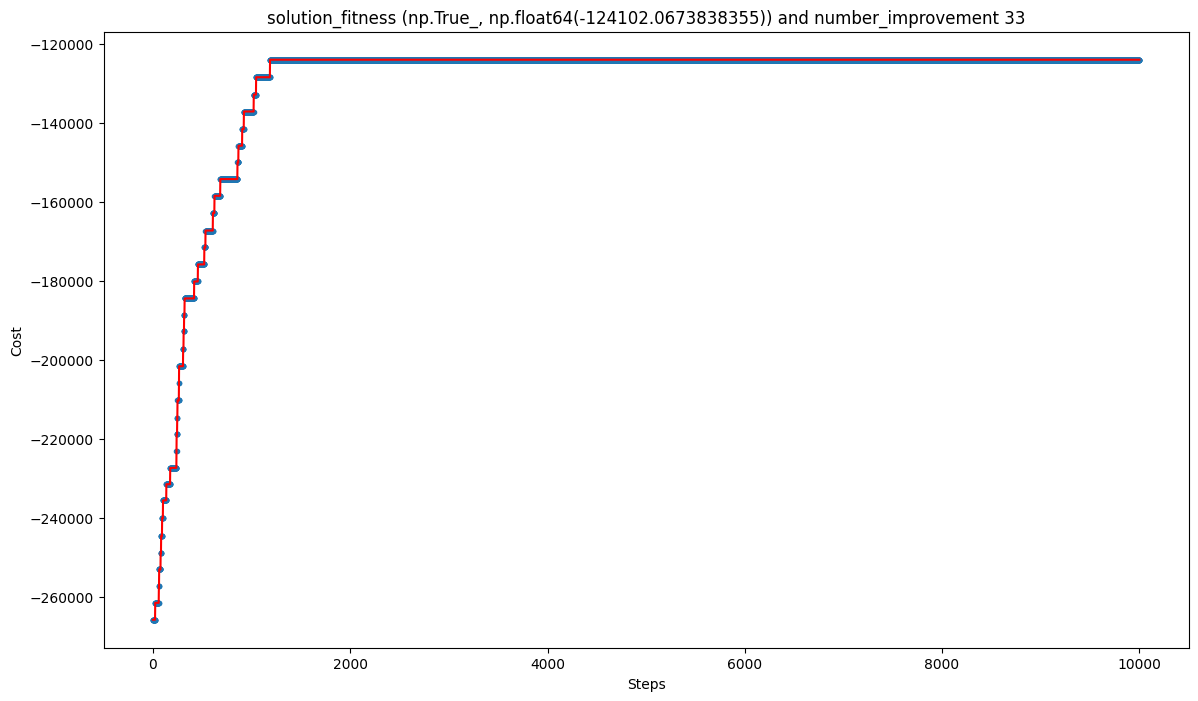

In [90]:
UNIVERSE_SIZE = UNIVERSE_SIZE_LIST[2]
NUM_SETS = NUM_SETS_LIST[2]
DENSITY = DENSITY_LIST[2]

experiments(UNIVERSE_SIZE, NUM_SETS, DENSITY, single_mutation_personalized, 0.06)